# Model 2: ResNet50 ile Transfer Learning Tabanlı Sınıflandırma

Bu notebook’ta, ResNet50 mimarisi kullanılarak Transfer Learning yaklaşımıyla
bir görüntü sınıflandırma modeli eğitilmiş ve test verisi üzerinde
detaylı performans analizi yapılmıştır.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import cycle

## 2. Veri Seti ve Ön İşleme (Data Augmentation)

Veri seti eğitim (train), doğrulama (validation) ve test olmak üzere
üç alt kümeye ayrılmıştır.

Eğitim verisi üzerinde:
- Rastgele yatay çevirme (RandomFlip)
- Rastgele döndürme (RandomRotation)
- Rastgele yakınlaştırma (RandomZoom)

işlemleri uygulanarak modelin genelleme yeteneği artırılmıştır.
Tüm görüntüler ResNet50 mimarisine uygun şekilde normalize edilmiştir.

In [ ]:
# ---- CONFIG ----
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 5

TRAIN_DIR = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/train"
VAL_DIR   = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/val"
TEST_DIR  = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/test"

OUTPUT_DIR = f"/content/drive/MyDrive/ResNet50_Results_Update2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- DATA AUGMENTATION ----
train_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15)
])

train_ds = image_dataset_from_directory(TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = image_dataset_from_directory(VAL_DIR,   image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_ds  = image_dataset_from_directory(TEST_DIR,  image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names

def preprocess(images, labels):
    images = train_augment(images)
    return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.


## 3. Model Mimarisi (ResNet50)

Bu çalışmada ImageNet veri seti üzerinde önceden eğitilmiş
ResNet50 modeli kullanılmıştır.

Özellik çıkarıcı katmanlar dondurulmuş, yalnızca sınıflandırma
katmanları eğitilmiştir. Bu sayede:
- Eğitim süresi azaltılmış
- Aşırı öğrenme riski düşürülmüş
- Daha kararlı bir öğrenme süreci elde edilmiştir


In [ ]:
# ---- MODEL ----
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5),
    keras.callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best_model.h5", save_best_only=True),
    keras.callbacks.CSVLogger(f"{OUTPUT_DIR}/train_log.csv")
]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4. Modelin Eğitimi

Model, belirlenen epoch sayısı boyunca eğitim ve doğrulama
veri setleri kullanılarak eğitilmiştir.

ReduceLROnPlateau callback’i ile doğrulama kaybı iyileşmediğinde
öğrenme oranı otomatik olarak düşürülmüştür.
En iyi model ağırlıkları ayrıca kaydedilmiştir.


In [ ]:
# ---- TRAIN ----
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ---- SAVE (TAM MODEL + AĞIRLIK DOSYASI) ----
model.save(f"{OUTPUT_DIR}/final_model.h5")  # TAM MODEL
model.save_weights(f"{OUTPUT_DIR}/resNet50_final_model.weights.h5")  # STREAMLIT İÇİN AĞIRLIK DOSYASI

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4185 - loss: 1.3866

111/111 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.4194 - loss: 1.3846 - val_accuracy: 0.7320 - val_loss: 0.7636 - learning_rate: 1.0000e-04
Epoch 2/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7427 - loss: 0.7168

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 347ms/step - accuracy: 0.7430 - loss: 0.7161 - val_accuracy: 0.7680 - val_loss: 0.6248 - learning_rate: 1.0000e-04
Epoch 3/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7962 - loss: 0.5817

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 343ms/step - accuracy: 0.7962 - loss: 0.5813 - val_accuracy: 0.8280 - val_loss: 0.5263 - learning_rate: 1.0000e-04
Epoch 4/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8406 - loss: 0.4934

111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - accuracy: 0.8405 - loss: 0.4932 - val_accuracy: 0.8320 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 5/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8529 - loss: 0.4115

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 343ms/step - accuracy: 0.8528 - loss: 0.4118 - val_accuracy: 0.8520 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.8796 - loss: 0.3654 - val_accuracy: 0.8360 - val_loss: 0.4466 - learning_rate: 1.0000e-04
Epoch 7/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8688 - loss: 0.3392

111/111 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - accuracy: 0.8687 - loss: 0.3396 - val_accuracy: 0.8640 - val_loss: 0.4198 - learning_rate: 1.0000e-04
Epoch 8/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8975 - loss: 0.3266

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 340ms/step - accuracy: 0.8976 - loss: 0.3262 - val_accuracy: 0.8640 - val_loss: 0.3959 - learning_rate: 1.0000e-04
Epoch 9/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9020 - loss: 0.2683

111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - accuracy: 0.9019 - loss: 0.2687 - val_accuracy: 0.8680 - val_loss: 0.3807 - learning_rate: 1.0000e-04
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.9099 - loss: 0.2828 - val_accuracy: 0.8480 - val_loss: 0.4268 - learning_rate: 1.0000e-04
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.9094 - loss: 0.2605 - val_accuracy: 0.8800 - val_loss: 0.3886 - learning_rate: 1.0000e-04
Epoch 12/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9166 - loss: 0.2401

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.9167 - loss: 0.2401 - val_accuracy: 0.8680 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 13/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9262 - loss: 0.2316

111/111 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - accuracy: 0.9261 - loss: 0.2317 - val_accuracy: 0.8760 - val_loss: 0.3556 - learning_rate: 1.0000e-04
Epoch 14/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - accuracy: 0.9138 - loss: 0.2386 - val_accuracy: 0.8720 - val_loss: 0.3749 - learning_rate: 1.0000e-04
Epoch 15/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9327 - loss: 0.2009

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.9327 - loss: 0.2011 - val_accuracy: 0.8760 - val_loss: 0.3515 - learning_rate: 1.0000e-04
Epoch 16/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9349 - loss: 0.2019

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.9349 - loss: 0.2019 - val_accuracy: 0.8840 - val_loss: 0.3265 - learning_rate: 1.0000e-04
Epoch 17/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 313ms/step - accuracy: 0.9323 - loss: 0.1941 - val_accuracy: 0.8840 - val_loss: 0.3657 - learning_rate: 1.0000e-04
Epoch 18/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 322ms/step - accuracy: 0.9383 - loss: 0.1795 - val_accuracy: 0.8600 - val_loss: 0.3759 - learning_rate: 1.0000e-04
Epoch 19/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step - accuracy: 0.9341 - loss: 0.1851 - val_accuracy: 0.8720 - val_loss: 0.3682 - learning_rate: 1.0000e-04
Epoch 20/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 319ms/step - accuracy: 0.9504 - loss: 0.1621 - val_accuracy: 0.8720 - val_loss: 0.3687 - learning_rate: 1.0000e-04
Epoch 21/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 311ms/step - accuracy: 0.9501 - loss: 0.1627 - val_accuracy: 0.8640 - val_loss: 0.3610 - learning_rate: 5.0000e-05
Epoch 22/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/s

## 5. Eğitim ve Doğrulama Doğrulukları (Accuracy)

Aşağıdaki grafikte modelin epoch bazlı eğitim ve doğrulama
doğruluk değerleri gösterilmektedir.


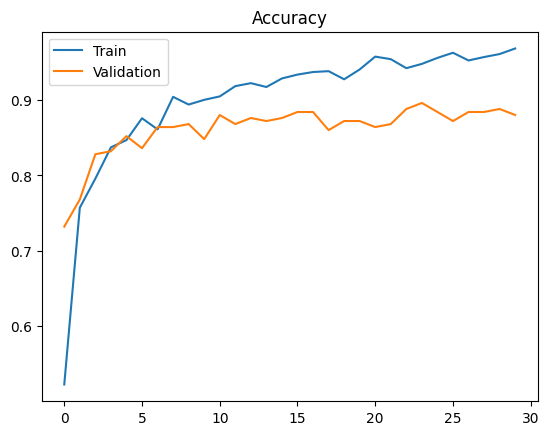

In [ ]:
# ---- LEARNING CURVES ----
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend(); plt.title("Accuracy")
plt.savefig(f"{OUTPUT_DIR}/accuracy_plot.png")

Eğitim doğruluğu %95 seviyelerine kadar yükselirken,
doğrulama doğruluğu %86–88 aralığında dengelenmiştir.
Bu durum modelin iyi öğrenmesine rağmen
hafif bir overfitting eğilimi olduğunu göstermektedir.


## 6. Eğitim ve Doğrulama Kayıp Değerleri (Loss)

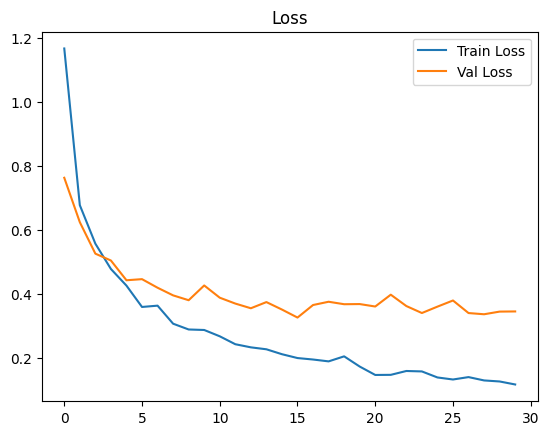

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.savefig(f"{OUTPUT_DIR}/loss_plot.png")

Eğitim kaybı düzenli şekilde azalırken,
doğrulama kaybının belirli bir noktadan sonra plato yaptığı görülmektedir.
Bu durum modelin genelleme sınırına ulaştığını göstermektedir.


## 7. Test Veri Seti Üzerinde Performans Değerlendirmesi

Modelin test veri seti üzerindeki performansı
Accuracy, Balanced Accuracy, MCC, Precision, Recall ve
F1-score metrikleri kullanılarak değerlendirilmiştir.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━

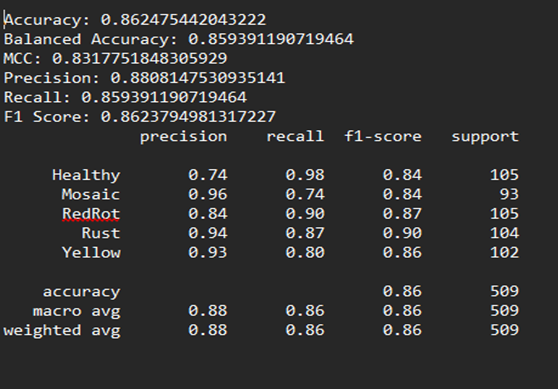

Elde edilen metrikler, modelin sınıflar arasında
dengeli ve güvenilir bir sınıflandırma performansı sunduğunu göstermektedir.


## 8. Test Veri Seti Karmaşıklık Matrisi (Confusion Matrix)

Karmaşıklık matrisi, modelin her sınıfı ne ölçüde doğru
sınıflandırdığını göstermektedir.
Ana diyagonal üzerindeki yüksek değerler,
doğru sınıflandırma oranının yüksek olduğunu ifade etmektedir.


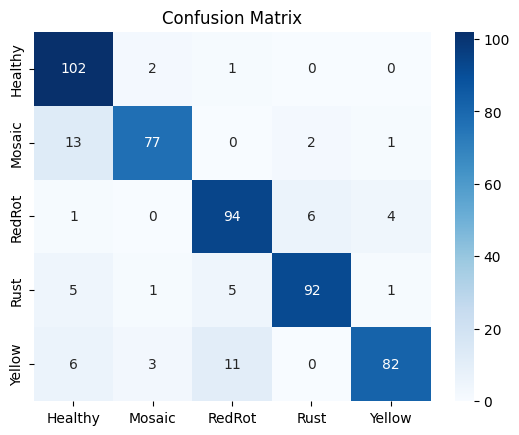

In [ ]:
# ---- CONFUSION MATRIX ----
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")

## 9. ROC Eğrisi ve ROC AUC Analizi

ROC eğrileri, modelin farklı eşik değerlerinde
sınıfları ayırt etme başarısını göstermektedir.


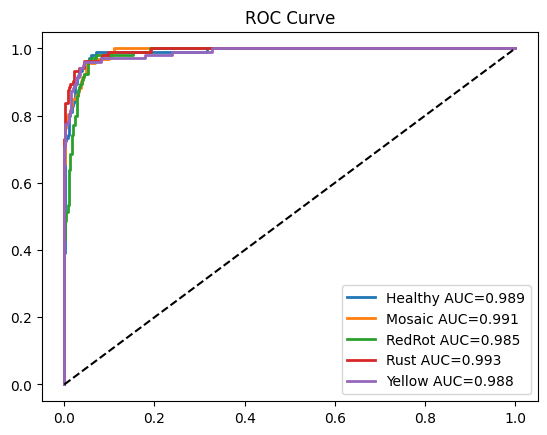

In [ ]:
# ---- ROC CURVE ----
y_true_bin = keras.utils.to_categorical(y_true, NUM_CLASSES)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} AUC={roc_auc[i]:.3f}")

plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title("ROC Curve")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")


ROC AUC değerlerinin tüm sınıflar için 0.98 ve üzerinde olması,
modelin ayırt edicilik gücünün oldukça yüksek olduğunu göstermektedir.


## 10. Genel Değerlendirme

ResNet50 tabanlı Transfer Learning modeli,
test veri seti üzerinde yüksek doğruluk ve
dengeli sınıflandırma performansı sergilemiştir.
